In [1]:
from dotenv import load_dotenv
load_dotenv(".env", override=True)
%load_ext autoreload
%autoreload 2

# Deepagent for Research

We will use the `deepagents` package to create a research agent, taking advantage of the native tools / middleware, but extending it with custom instructions and tools for the research task. 

## Instructions
 
First, we'll define a prompt that instructs our agent to use available search tools. To prevent excessive tool calls and maintain research focus, we'll use [a few prompting techniques for agents](https://youtu.be/XSZP9GhhuAc?si=zowpViL-2j-vI9hA):

### 1. Think Like The Agent
What instructions would you give a new work colleague?
- **Read the question carefully** - What specific information does the user need?
- **Start with broader searches** - Use broad, comprehensive queries first
- **After each search, pause and assess** - Do I have enough to answer? What's still missing?
- **Execute narrower searches as you gather information** - Fill in the gaps.

### 2. Concrete Heuristics (Prevent "Spin-Out" on excessive tool calls)
Use **Hard Limits** to prevent the research agent from calling tools excessively:
- **Stop when you can answer confidently** - Don't keep searching for perfection.
- **Give it budgets** - Use 2-3 search tool calls for simple queries. Use up to 5 for complex queries.
- **Limit** - Always stop after 5 search tool calls if you cannot find the right source(s).

### 3. Show your thinking
After each search tool calling, use [`think_tool` to analyze the results](https://www.anthropic.com/engineering/claude-think-tool):
- What key information did I find? 
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?

### Results
These techniques transform problematic research behavior like:
```
"best coffee shops SF" → "Saint Frank Coffee details" → "Sightglass Coffee details" → "Ritual Coffee details" → etc. (20+ searches)
```

Into efficient patterns like:
```
"best coffee shops SF" → ThinkTool(analyze results) → "SF specialty coffee quality ratings" → ThinkTool(assess completeness) → provide answer (3-5 searches total)
```

The key insight: **Think like a human researcher with limited time** - this prevents the "spin-out problem" where agents continue searching indefinitely.

In [ ]:
# TODO(Claude): can we read these from the top-level utils folder? since we want all quickstart examples to use the same utils and dont want to re-add to each folder
from utils import show_prompt, format_messages
from research_agent.prompts import (
    RESEARCHER_INSTRUCTIONS,
    TODO_USAGE_INSTRUCTIONS,
    FILE_USAGE_INSTRUCTIONS,
    SUBAGENT_USAGE_INSTRUCTIONS,
)

In [4]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Complex queries**: Use up to 5 search tool calls maximum                                                   │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                       

In [5]:
INSTRUCTIONS = (
    "# TODO MANAGEMENT\n"
    + TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# FILE SYSTEM USAGE\n"
    + FILE_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# SUB-AGENT DELEGATION\n"
    + SUBAGENT_USAGE_INSTRUCTIONS
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # TODO MANAGEMENT                                                                                              │
│  Based upon the user's request:                                                                                 │
│  │                                                                                                              │
│  1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.           │
│  2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan.  │
│  3. Reflect on what you've done and the TODO.                                                                   │
│  4. Mark you task as completed, and proceed to the next TODO.                                                   │
│  5. Continue this process until you have completed all TODOs.                                                   │
│                                                                                                                 │
│  IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY  │
│  user request.                                                                                                  │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # FILE SYSTEM USAGE                                                                                            │
│  You have access to a virtual file system to help you retain and save context.                                  │
│                                                                                                                 │
│  ## Workflow Process                                                                                            │
│  1. **Orient**: Use ls() to see existing files before starting work                                             │
│  2. **Save**: Use write_file() to store the user's request so that we can keep it for later                     │
│  3. **Research**: Proceed with research. The search tool will write files.                                      │
│  4. **Read**: Once you are satisfied with the collected sources, read the files and use them to answer the      │
│  user's question directly.                                                                                      │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # SUB-AGENT DELEGATION                                                                                         │
│  You can delegate tasks to sub-agents.                                                                          │
│                                                       

## Tools 

We'll amend the native deepagents tool with a few research-specific tools.

### Search Tool 

We'll build a search tool that offloads raw contents to files and returns only a summary to the agent. This is a common pattern for long-running agent trajectories, [as we've seen with Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus)! 

1. **Search Execution (`run_tavily_search`)**: Performs the actual web search using Tavily API with configurable parameters for results count and topic filtering.

2. **Content Summarization (`summarize_webpage_content`)**: Uses a lightweight model (GPT-4o-mini) to generate structured summaries of webpage content, producing both a descriptive filename and key learnings summary.

3. **Result Processing (`process_search_results`)**: Fetches full webpage content via HTTP, converts HTML to markdown using `markdownify`, and generates summaries for each result.

4. **Context Offloading (`tavily_search` tool)**: The main tool that:
   - Executes search and processes results
   - Saves full content to files in agent state (context offloading)
   - Returns only minimal summaries to the agent (prevents context spam)
   - Uses LangGraph `Command` to update both files and messages

### Think Tool 

We'll provide a think tool; a reflection mechanism for agents to analyze findings, assess gaps, and plan next steps in their research workflow. [Some research](https://www.anthropic.com/engineering/claude-think-tool) has suggested that a think tools can help steer agents towards better solutions, and the think tools is a useful way to help audit agent decision making. Note that some notes, such as Claude, now [include interleaved thinking with the SDK](https://docs.claude.com/en/docs/build-with-claude/extended-thinking). 

In [ ]:
from research_agent.tools import tavily_search, think_tool
tools = [tavily_search, think_tool]


## Subagent

You can specify [custom subagents](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#subagents) as a means of context isolation. 

In [ ]:
# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "system_prompt": RESEARCHER_INSTRUCTIONS,
    "tools": tools, # Use actual tool objects, not strings
}

## Putting it all together

Now, we create our deepagent with these components. 

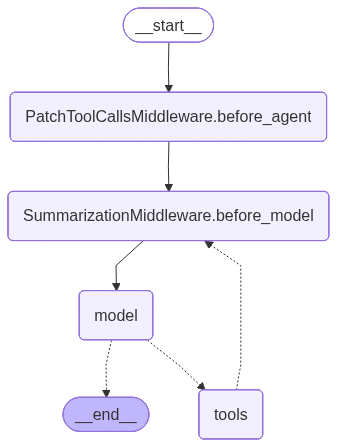

In [ ]:
from datetime import datetime
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from deepagents import create_deep_agent

# Create agent using create_react_agent directly
model = init_chat_model(model="anthropic:claude-sonnet-4-5-20250929", temperature=0.0)

# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Create the agent
agent = create_deep_agent(
      model=model,
      tools=tools,
      system_prompt=INSTRUCTIONS,
      subagents=[research_sub_agent],
  )
  
# Show the agent
display(Image(agent.get_graph().draw_mermaid_png()))

## Deep Agent Middleware

The `create_deep_agent` function automatically configures several middleware components to enhance agent reliability and efficiency. Two key middleware components are:

### 1. PatchToolCallsMiddleware

**Purpose**: Handles "dangling" tool calls that lack corresponding tool responses in the message history.

**Problem it solves**: When an agent workflow is interrupted (e.g., user sends a new message while tool calls are pending), AI messages with tool calls may exist without their corresponding `ToolMessage` responses. This creates an invalid message sequence that causes model errors.

**How it works** (from `libs/deepagents/deepagents/middleware/patch_tool_calls.py`):
- Runs **before the agent** processes messages
- Scans message history for any `AIMessage` with tool calls
- For each tool call, checks if a corresponding `ToolMessage` exists
- If missing, inserts a synthetic `ToolMessage` explaining the tool call was cancelled
- This ensures the message history remains valid and the model can continue processing

**Example scenario**: User asks agent to search 3 topics in parallel → Agent makes 3 `tavily_search` tool calls → User interrupts with new message → PatchToolCallsMiddleware creates placeholder responses for any incomplete tool calls.

### 2. SummarizationMiddleware

**Purpose**: Prevents context window overflow by automatically summarizing older conversation history when token limits are approached.

**Problem it solves**: Long-running agent sessions accumulate messages that eventually exceed the model's context window. Simply truncating old messages loses important context.

**How it works** (from `langchain.agents.middleware.summarization`):
- Monitors total token count in message history using `token_counter`
- When tokens exceed `max_tokens_before_summary` threshold (default: 170,000 for this agent)
- Intelligently partitions messages:
  - Keeps recent `messages_to_keep` messages (default: 6 for this agent)
  - Summarizes older messages while preserving AI/Tool message pairs
- Uses the configured model to generate a concise summary
- Replaces old messages with a single `HumanMessage` containing the summary

**Key feature**: Smart cutoff detection ensures AI messages with tool calls are never separated from their tool responses, maintaining conversation coherence.

**Configuration in this notebook**:
```python
SummarizationMiddleware(
    model=model,
    max_tokens_before_summary=170000,  # Trigger summarization at 170k tokens
    messages_to_keep=6,                 # Always preserve 6 most recent messages
)
```

These middleware components work together to enable reliable, long-running research sessions without context overflow or message history corruption.

In [8]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an very brief overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

/Users/rlm/Desktop/Code/deepagents/examples/deep_research/.venv/lib/python3.13/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `general-fields` - serialized value may not be as expected [field_name='files', input_value='# Search Result: The Def... action at this time.\n', input_type=str])
  PydanticSerializationUnexpectedValue(Expected `general-fields` - serialized value may not be as expected [field_name='files', input_value='# Search Result: Creatin... All Rights Reserved.\n', input_type=str])
  return self.__pydantic_serializer__.to_python(


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an very brief overview of Model Context Protocol (MCP).                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you get a brief overview of Model Context Protocol (MCP). Let me research this for you.               │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) to gather key information about what it is, its         │
│ purpose, and main features",                                                                                    │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Provide a very brief overview based on research findings",                                    │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01A2cZRHHR7RS1XdPPp3rUcy                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) to gather key information about what   │
│ it is, its purpose, and main features', 'status': 'in_progress'}, {'content': 'Provide a very brief overview    │
│ based on research findings', 'status': 'pending'}]                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research Model Context Protocol (MCP) and provide a comprehensive overview covering: what MCP │
│ is, its main purpose and goals, key features and capabilities, who developed it, and its significance in the    │
│ AI/ML ecosystem. Focus on gathering authoritative information from official sources, documentation, and         │
│ reputable tech publications.",                                                                                  │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: toolu_01VRERvS3gTTu8iYbSyCZxJk                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my research, here's a comprehensive overview of the Model Context Protocol (MCP):                      │
│                                                                                                                 │
│ ## What is Model Context Protocol (MCP)?                                                                        │
│                                                                                                                 │
│ The Model Context Protocol (MCP) is an **open-source framework and standardization layer** that facilitates     │
│ seamless communication between AI systems (particularly Large Language Models) and external tools, services,    │
│ and data sources. It functions as a universal interface that enables AI applications to interact with various   │
│ external resources in a standardized way.                                                                       │
│                                                                                                                 │
│ ## Main Purpose and Goals                                                                                       │
│                                                                                                                 │
│ MCP's primary objectives include:                                                                               │
│                                                                                                                 │
│ 1. **Standardizing AI-Tool Integration**: Creating a universal protocol for AI systems to communicate with      │
│ external tools and services, similar to how USB-C provides a standard connection for devices                    │
│ 2. **Solving Integration Challenges**: Addressing the complex and fragmented landscape of AI tool integration   │
│ that previously required custom coding for each tool                                                            │
│ 3. **Enabling Context-Aware AI**: Allowing AI agents to access real-time data and external resources to enhance │
│ their capabilities and decision-making                                                                          │
│ 4. **Streamlining Development**: Reducing the need for custom integration code and enabling "plug-and-play"     │
│ functionality for AI tools                                                                                      │
│                                                                                                                 │
│ ## Key Features and Capabilities                                                                                │
│                                                                                                                 │
│ - **Universal Standardization**: Provides a consistent interface for AI systems to interact with diverse        │
│ external tools and data sources                                                                                 │
│ - **Plug-and-Play Architecture**: Enables easy integration of new tools without requiring custom development    │
│ for each integration                                                                                            │
│ - **Real-Time Data Access**: Allows AI systems to access live data and external services dynamically            │
│ - **Multi-Agent Support**: Facilitates collaboration between multiple AI agents by providing standardized       │
│ access to shared tools and resources                                                                            │
│ - **Error Mitigation**: Reduces integration errors that commonly hinder multi-agent operations                  │
│ - **Enhanced AI Capabilities**: Significantly expands what AI systems can accomplish by giving them access to   │
│ external tools and data                                

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) to gather key information about what it is, its         │
│ purpose, and main features",                                                                                    │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Provide a very brief overview based on research findings",                                    │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01J4y2nf2ZMmzXsfzBEJoM5U                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) to gather key information about what   │
│ it is, its purpose, and main features', 'status': 'completed'}, {'content': 'Provide a very brief overview      │
│ based on research findings', 'status': 'in_progress'}]                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ## Model Context Protocol (MCP) - Brief Overview                                                                │
│                                                                                                                 │
│ **Model Context Protocol (MCP)** is an open-source framework developed by Anthropic that serves as a universal  │
│ interface for AI systems to communicate with external tools, services, and data sources.                        │
│                                                                                                                 │
│ **Key Points:**                                                                                                 │
│ - **Purpose**: Standardizes how AI models (like LLMs) connect to external tools and data, similar to how USB-C  │
│ provides universal device connectivity                                                                          │
│ - **Problem it solves**: Eliminates the need for custom integration code for each tool, enabling                │
│ "plug-and-play" functionality                                                                                   │
│ - **Benefits**: Allows AI systems to access real-time data, enhances multi-agent collaboration, and             │
│ significantly expands AI capabilities                                                                           │
│ - **Significance**: Positioned to become an industry standard that makes AI more practical and powerful by      │
│ seamlessly connecting it to the broader digital ecosystem                                                       │
│                                                                                                                 │
│ Think of MCP as the "plumbing" that connects AI brains to the tools and data they need to be truly useful in    │
│ real-world applications.                                                                                        │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) to gather key information about what it is, its         │
│ purpose, and main features",                                                                                    │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Provide a very brief overview based on research findings",                                    │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01AYJw7VuMLYCZFadsj85Hgb                                                                           │
╰─────────────────────────────────────────────────────────

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) to gather key information about what   │
│ it is, its purpose, and main features', 'status': 'completed'}, {'content': 'Provide a very brief overview      │
│ based on research findings', 'status': 'completed'}]                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 

https://smith.langchain.com/public/5bcbf8ea-f5ac-458d-b28b-fdeca132e7b5/r